In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from warnings import filterwarnings
from IPython.display import clear_output
filterwarnings('ignore')

## Load data

In [2]:
df = pd.read_csv('Data_Preprocessed.csv')
df.shape

(283043, 33)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['kilometer']), df['kilometer'],
                                                    test_size=0.1, random_state=42)
X_train.shape, X_val.shape

((254738, 32), (28305, 32))

In [4]:
# В качестве baseline возьмем наивный классификатор, его качество будет около 76%
df['kilometer'].value_counts(normalize=True)

1    0.762121
0    0.237879
Name: kilometer, dtype: float64

In [5]:
metrics = pd.DataFrame({'Model':['KNN', 'LogReg', 'NN'],
                        'Accuracy':[0.86, 0.85, 0.86],
                        'Precision':[0.88, 0.87, 0.89],
                        'Recall':[0.95, 0.95, 0.95],
                        'F1':[0.91, 0.91, 0.91]})
display(metrics)

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.86,0.88,0.95,0.91
1,LogReg,0.85,0.87,0.95,0.91
2,NN,0.86,0.89,0.95,0.91


## Random Forest

#### some things to pass hw

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
oob_errors = {"sqrt":[], "log2":[], None:[]}

for max_feature in ["sqrt", "log2", None]:
    for n_estimators in tqdm(np.arange(15, 176, 15)):
        model = RandomForestClassifier(oob_score=True, warm_start=True, random_state=42,
                                       max_features=max_feature, n_estimators=n_estimators)
        model.fit(df.drop(columns=['kilometer']), df['kilometer'])
        oob_errors[max_feature].append(1 - model.oob_score_)
        
oob_errors = pd.DataFrame(oob_errors, index=np.arange(15, 176, 15)) 

100%|██████████| 11/11 [30:02<00:00, 163.86s/it]


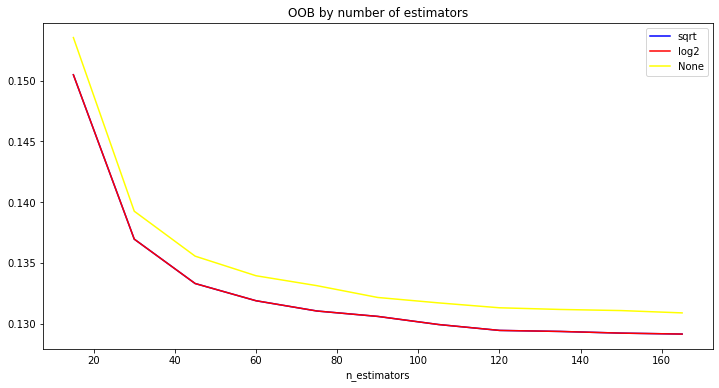

In [8]:
plt.figure(figsize=(12,6))
plt.plot(oob_errors['sqrt'], label='sqrt', color='blue')
plt.plot(oob_errors['log2'], label='log2', color='red')
plt.plot(oob_errors[None], label='None', color='yellow')
plt.xlabel('n_estimators')
plt.title('OOB by number of estimators')
plt.legend()
plt.plot();

In [9]:
errors = {'train':[], 'test':[]}

for n_estimators in tqdm(np.arange(15, 176, 15)):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight='balanced', n_jobs=-1)
    model.fit(X_train, y_train)
    errors['train'].append(model.score(X_train, y_train))
    errors['test'].append(model.score(X_val, y_val))

errors = pd.DataFrame(errors, index=np.arange(15, 176, 15)) 

100%|██████████| 11/11 [03:44<00:00, 20.42s/it]


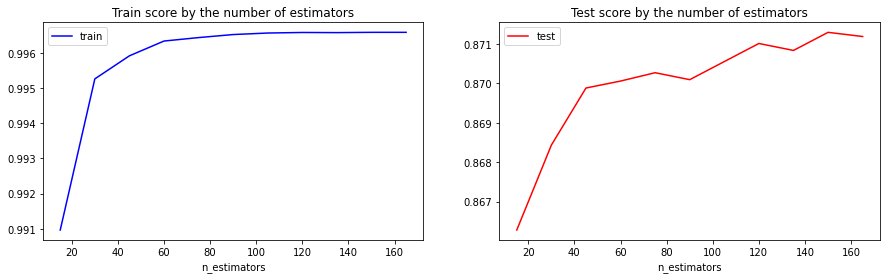

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(errors['train'], label='train', color='blue')
ax[1].plot(errors['test'], label='test', color='red')
ax[0].set_xlabel('n_estimators')
ax[1].set_xlabel('n_estimators')
ax[0].set_title('Train score by the number of estimators')
ax[1].set_title('Test score by the number of estimators')
ax[0].legend()
ax[1].legend()
plt.plot();

In [7]:
def objective(trial):
    # params
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    max_features = trial.suggest_categorical('max_features', ["sqrt", "log2", None])
    classifier = RandomForestClassifier(random_state=42, criterion=criterion, n_estimators=n_estimators, n_jobs=-1,
                                        max_depth=max_depth, max_features=max_features, class_weight='balanced')
    classifier.fit(X_train, y_train)
    score = roc_auc_score(y_val, classifier.predict(X_val))
    return score

In [8]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=30*60, show_progress_bar=True)

[I 2021-03-02 13:07:14,903] A new study created in memory with name: no-name-c933dcc0-2a20-4abd-8d61-0baaafac2837


[I 2021-03-02 13:07:39,042] Trial 0 finished with value: 0.8145775140447936 and parameters: {'criterion': 'entropy', 'n_estimators': 151, 'max_depth': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.8145775140447936.
[I 2021-03-02 13:08:11,681] Trial 1 finished with value: 0.8166401775815384 and parameters: {'criterion': 'entropy', 'n_estimators': 57, 'max_depth': 14, 'max_features': None}. Best is trial 1 with value: 0.8166401775815384.
[I 2021-03-02 13:08:41,186] Trial 2 finished with value: 0.814063702856646 and parameters: {'criterion': 'gini', 'n_estimators': 183, 'max_depth': 18, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8166401775815384.
[I 2021-03-02 13:09:10,362] Trial 3 finished with value: 0.7935230218674701 and parameters: {'criterion': 'gini', 'n_estimators': 160, 'max_depth': 28, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8166401775815384.
[I 2021-03-02 13:10:24,896] Trial 4 finished with value: 0.7882493877777774 and parameters: {'crit

[I 2021-03-02 13:29:04,579] Trial 35 finished with value: 0.8178717475101354 and parameters: {'criterion': 'entropy', 'n_estimators': 79, 'max_depth': 13, 'max_features': None}. Best is trial 20 with value: 0.8181556454014408.
[I 2021-03-02 13:29:36,899] Trial 36 finished with value: 0.8177530469636641 and parameters: {'criterion': 'entropy', 'n_estimators': 64, 'max_depth': 13, 'max_features': None}. Best is trial 20 with value: 0.8181556454014408.
[I 2021-03-02 13:29:47,065] Trial 37 finished with value: 0.8006813549391332 and parameters: {'criterion': 'entropy', 'n_estimators': 94, 'max_depth': 10, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.8181556454014408.
[I 2021-03-02 13:30:32,295] Trial 38 finished with value: 0.813758652804007 and parameters: {'criterion': 'gini', 'n_estimators': 82, 'max_depth': 15, 'max_features': None}. Best is trial 20 with value: 0.8181556454014408.
[I 2021-03-02 13:30:48,170] Trial 39 finished with value: 0.8139220385852689 and parameters: {

In [9]:
%%time
params = {**study.best_params, **{'n_jobs':-1, 'random_state':42, 'class_weight':'balanced'}}
model = RandomForestClassifier(**params)
acc_scores = cross_val_score(model, X_train, y_train, scoring='accuracy')
precision_scores = cross_val_score(model, X_train, y_train, scoring='precision')
recall_scores = cross_val_score(model, X_train, y_train, scoring='recall')
f1_scores = cross_val_score(model, X_train, y_train, scoring='f1')

Wall time: 9min 37s


In [10]:
acc_score = round(acc_scores.mean(), 3)
precision_score = round(precision_scores.mean(), 3)
recall_score = round(recall_scores.mean(), 3)
f1_score = round(f1_scores.mean(), 3)
metrics = metrics.append({'Model':'RandomForest', 'Accuracy':acc_score,
                          'Precision':precision_score, 'Recall':recall_score, 'F1':f1_score}, ignore_index=True)
metrics

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.860,0.880,0.950,0.910
1,LogReg,0.850,0.870,0.950,0.910
2,NN,0.860,0.890,0.950,0.910
3,RandomForest,0.848,0.919,0.878,0.898


In [11]:
model.fit(X_train, y_train)
feature_importances = dict(zip(X_train.columns, model.feature_importances_))
feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True) )
feature_importances

{'Age': 0.49955076300125717,
 'price': 0.15650094497041092,
 'powerPS': 0.10812514198645436,
 'FuelType_benzin': 0.10056408852122789,
 'model': 0.038097776320199714,
 'brand': 0.035880922892191476,
 'VehicleType_kombi': 0.013526957952025269,
 'manual gearbox': 0.00623247444075762,
 'VehicleType_cabrio': 0.003919823403130463,
 'VehicleType_kleinwagen': 0.0037491723947024485,
 'VehicleType_limousine': 0.0028806271374094824,
 'VehicleType_bus': 0.0024998927229034277,
 'PostalCode_1': 0.002469604398300411,
 'PostalCode_2': 0.0024637016294107683,
 'PostalCode_4': 0.002296890282453922,
 'notRepairedDamage': 0.002234603439097165,
 'PostalCode_3': 0.0021493036319695604,
 'PostalCode_6': 0.0021366709636497076,
 'PostalCode_5': 0.00208831996638483,
 'PostalCode_8': 0.0019844579789880406,
 'PostalCode_7': 0.0019218010821544064,
 'PostalCode_9': 0.0018113287057683087,
 'PostalCode_0': 0.0016629485786989542,
 'FuelType_diesel': 0.001273475255934518,
 'VehicleType_suv': 0.0010487019656862655,
 'Vehi

Precision is better -> we choose not a lot of false positive example, but recall lower -> we choose not all relevant items. For the model it's harder to find all correct answers, but confidence in found answers much better.

## Gradient Boosting

In [12]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [13]:
errors = {'train':[], 'test':[]}

for n_estimators in np.arange(15, 176, 15):
    
    model = XGBClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    errors['train'].append(model.score(X_train, y_train))
    errors['test'].append(model.score(X_val, y_val))
    clear_output()
    
errors = pd.DataFrame(errors, index=np.arange(15, 176, 15)) 

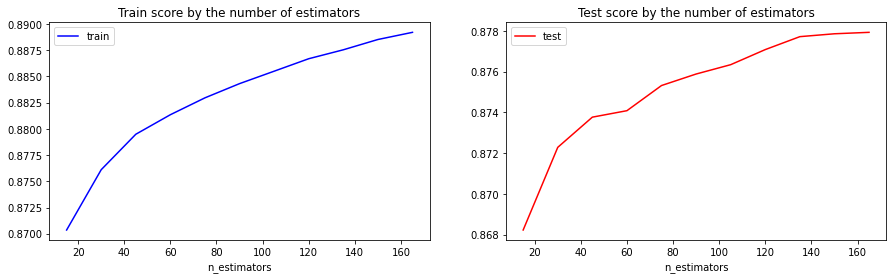

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(errors['train'], label='train', color='blue')
ax[1].plot(errors['test'], label='test', color='red')
ax[0].set_xlabel('n_estimators')
ax[1].set_xlabel('n_estimators')
ax[0].set_title('Train score by the number of estimators')
ax[1].set_title('Test score by the number of estimators')
ax[0].legend()
ax[1].legend()
plt.plot();

In [15]:
errors = {'train':[], 'test':[]}

for n_estimators in np.arange(15, 176, 15):
    
    model = CatBoostClassifier(n_estimators=n_estimators, random_state=42, verbose=False)
    model.fit(X_train, y_train)
    errors['train'].append(model.score(X_train, y_train))
    errors['test'].append(model.score(X_val, y_val))
    
errors = pd.DataFrame(errors, index=np.arange(15, 176, 15)) 

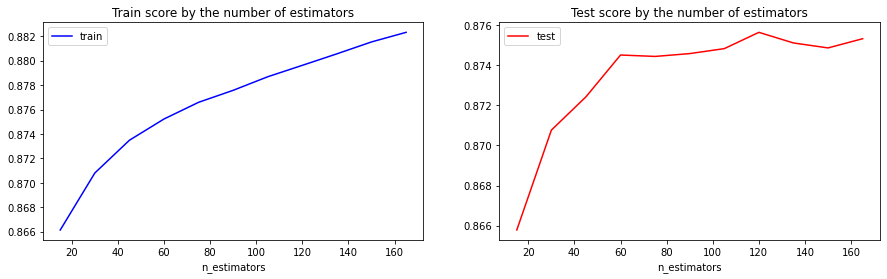

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(errors['train'], label='train', color='blue')
ax[1].plot(errors['test'], label='test', color='red')
ax[0].set_xlabel('n_estimators')
ax[1].set_xlabel('n_estimators')
ax[0].set_title('Train score by the number of estimators')
ax[1].set_title('Test score by the number of estimators')
ax[0].legend()
ax[1].legend()
plt.plot();

#### hyperopt

In [17]:
sample_weights = (1 / pd.concat([X_train, y_train], axis=1).groupby('kilometer')['kilometer'].transform('size'))

In [18]:
def objective(trial):
    # params
    max_depth = trial.suggest_int('max_depth', 3, 15)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 0.3)
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    # model
    classifier = XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                               booster=booster, verbosity=0, random_state=42, n_jobs=-1)
    classifier.fit(X_train, y_train, sample_weight=sample_weights)
    score = roc_auc_score(y_val, classifier.predict(X_val))
    return score

In [19]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=30*60, show_progress_bar=True)

[I 2021-03-02 13:51:28,780] A new study created in memory with name: no-name-56e5fc44-5eae-4e76-8671-d6a054d9724d


[I 2021-03-02 13:51:36,754] Trial 0 finished with value: 0.7454356534344311 and parameters: {'max_depth': 13, 'n_estimators': 232, 'learning_rate': 0.03857533108982766, 'booster': 'gblinear'}. Best is trial 0 with value: 0.7454356534344311.
[I 2021-03-02 13:52:24,610] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 6, 'n_estimators': 446, 'learning_rate': 0.0940262845064522, 'booster': 'dart'}. Best is trial 0 with value: 0.7454356534344311.
[I 2021-03-02 13:53:05,091] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 6, 'n_estimators': 402, 'learning_rate': 0.2593020180995164, 'booster': 'dart'}. Best is trial 0 with value: 0.7454356534344311.
[I 2021-03-02 13:53:12,527] Trial 3 finished with value: 0.5 and parameters: {'max_depth': 12, 'n_estimators': 180, 'learning_rate': 0.03833350188445537, 'booster': 'gbtree'}. Best is trial 0 with value: 0.7454356534344311.
[I 2021-03-02 13:53:15,819] Trial 4 finished with value: 0.7582056583584336 and parameters: {'m

[I 2021-03-02 14:00:58,297] Trial 33 finished with value: 0.5 and parameters: {'max_depth': 15, 'n_estimators': 467, 'learning_rate': 0.2562420883221316, 'booster': 'dart'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:01:16,029] Trial 34 finished with value: 0.7612334021957531 and parameters: {'max_depth': 13, 'n_estimators': 428, 'learning_rate': 0.11230987129492347, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:01:34,485] Trial 35 finished with value: 0.7672934446588033 and parameters: {'max_depth': 11, 'n_estimators': 493, 'learning_rate': 0.220643380634958, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:01:41,315] Trial 36 finished with value: 0.7625422309974745 and parameters: {'max_depth': 14, 'n_estimators': 223, 'learning_rate': 0.252794216941981, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:02:01,487] Trial 37 finished with v

[I 2021-03-02 14:09:44,612] Trial 66 finished with value: 0.7691781781467464 and parameters: {'max_depth': 15, 'n_estimators': 461, 'learning_rate': 0.2822923590109323, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:09:57,950] Trial 67 finished with value: 0.7694097132243105 and parameters: {'max_depth': 15, 'n_estimators': 433, 'learning_rate': 0.2973735822384381, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:10:15,578] Trial 68 finished with value: 0.7619069760380174 and parameters: {'max_depth': 7, 'n_estimators': 465, 'learning_rate': 0.11919954081431358, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:10:28,136] Trial 69 finished with value: 0.7678491288449574 and parameters: {'max_depth': 15, 'n_estimators': 391, 'learning_rate': 0.2997996640875119, 'booster': 'gblinear'}. Best is trial 16 with value: 0.7706410933700568.
[I 2021-03-02 14:10:39,968] Tria

[I 2021-03-02 14:19:17,148] Trial 99 finished with value: 0.7703842826674082 and parameters: {'max_depth': 9, 'n_estimators': 478, 'learning_rate': 0.2917162869674708, 'booster': 'gblinear'}. Best is trial 94 with value: 0.7710759548924121.

Wall time: 27min 48s


In [20]:
%%time
params = {**study.best_params, **{'n_jobs':-1, 'random_state':42}}
model = XGBClassifier(**params)
acc_scores = cross_val_score(model, X_train, y_train, scoring='accuracy')
precision_scores = cross_val_score(model, X_train, y_train, scoring='precision')
recall_scores = cross_val_score(model, X_train, y_train, scoring='recall')
f1_scores = cross_val_score(model, X_train, y_train, scoring='f1')

Wall time: 4min 19s


In [21]:
acc_score = round(acc_scores.mean(), 3)
precision_score = round(precision_scores.mean(), 3)
recall_score = round(recall_scores.mean(), 3)
f1_score = round(f1_scores.mean(), 3)
metrics = metrics.append({'Model':'XGBoost', 'Accuracy':acc_score,
                          'Precision':precision_score, 'Recall':recall_score, 'F1':f1_score}, ignore_index=True)
metrics

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.860,0.880,0.950,0.910
1,LogReg,0.850,0.870,0.950,0.910
2,NN,0.860,0.890,0.950,0.910
3,RandomForest,0.848,0.919,0.878,0.898
4,XGBoost,0.845,0.857,0.957,0.904


In [28]:
def objective(trial):
    # params
    depth = trial.suggest_int('depth', 3, 7)
    iterations = trial.suggest_int('iterations', 50, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.001, 0.3)
    l2_leaf_reg = trial.suggest_uniform('l2_leaf_reg', 0.001, 0.3)
    loss_function = trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy'])
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    # model
    classifier = CatBoostClassifier(depth=depth, iterations=iterations, learning_rate=learning_rate,
                                    l2_leaf_reg=l2_leaf_reg, loss_function=loss_function, grow_policy=grow_policy,
                                    random_seed=42, verbose=False)
    classifier.fit(X_train, y_train, sample_weight=sample_weights)
    score = roc_auc_score(y_val, classifier.predict(X_val))
    return score

In [29]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=30*60, show_progress_bar=True)

[I 2021-03-02 14:44:06,269] A new study created in memory with name: no-name-face7cb8-405d-4d54-9dc8-22833a51e891


[I 2021-03-02 14:44:25,412] Trial 0 finished with value: 0.8220543027395326 and parameters: {'depth': 6, 'iterations': 180, 'learning_rate': 0.25309184916509864, 'l2_leaf_reg': 0.2890199997731102, 'loss_function': 'CrossEntropy', 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.8220543027395326.
[I 2021-03-02 14:44:37,318] Trial 1 finished with value: 0.813652322648789 and parameters: {'depth': 3, 'iterations': 261, 'learning_rate': 0.2760430429742629, 'l2_leaf_reg': 0.05670710480205088, 'loss_function': 'CrossEntropy', 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.8220543027395326.
[I 2021-03-02 14:45:03,556] Trial 2 finished with value: 0.8210730563906959 and parameters: {'depth': 6, 'iterations': 406, 'learning_rate': 0.20942358632049085, 'l2_leaf_reg': 0.09553509941929443, 'loss_function': 'Logloss', 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.8220543027395326.
[I 2021-03-02 14:45:28,055] Trial 3 finished with value: 0.8092162692901328 

[I 2021-03-02 14:59:01,489] Trial 26 finished with value: 0.823730654657668 and parameters: {'depth': 7, 'iterations': 396, 'learning_rate': 0.03750666632969667, 'l2_leaf_reg': 0.03721329528316249, 'loss_function': 'CrossEntropy', 'grow_policy': 'Depthwise'}. Best is trial 19 with value: 0.8255289506837187.
[I 2021-03-02 14:59:38,406] Trial 27 finished with value: 0.8214999297803454 and parameters: {'depth': 5, 'iterations': 436, 'learning_rate': 0.0977872404510998, 'l2_leaf_reg': 0.12845167819301945, 'loss_function': 'Logloss', 'grow_policy': 'Depthwise'}. Best is trial 19 with value: 0.8255289506837187.
[I 2021-03-02 15:00:43,147] Trial 28 finished with value: 0.8252835614580706 and parameters: {'depth': 7, 'iterations': 495, 'learning_rate': 0.0669053327114645, 'l2_leaf_reg': 0.08546357206924542, 'loss_function': 'CrossEntropy', 'grow_policy': 'Depthwise'}. Best is trial 19 with value: 0.8255289506837187.
[I 2021-03-02 15:01:26,033] Trial 29 finished with value: 0.8233349229084808 a

In [36]:
%%time
params = {**study.best_params, **{'verbose':False, 'random_seed':42}}
model = CatBoostClassifier(**params)
acc_scores = cross_val_score(model, X_train, y_train, scoring='accuracy')
precision_scores = cross_val_score(model, X_train, y_train, scoring='precision')
recall_scores = cross_val_score(model, X_train, y_train, scoring='recall')
f1_scores = cross_val_score(model, X_train, y_train, scoring='f1')

Wall time: 15min 22s


In [37]:
acc_score = round(acc_scores.mean(), 3)
precision_score = round(precision_scores.mean(), 3)
recall_score = round(recall_scores.mean(), 3)
f1_score = round(f1_scores.mean(), 3)
metrics = metrics.append({'Model':'CatBoost', 'Accuracy':acc_score,
                          'Precision':precision_score, 'Recall':recall_score, 'F1':f1_score}, ignore_index=True)
metrics

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.860,0.880,0.950,0.910
1,LogReg,0.850,0.870,0.950,0.910
2,NN,0.860,0.890,0.950,0.910
3,RandomForest,0.848,0.919,0.878,0.898
4,XGBoost,0.845,0.857,0.957,0.904
5,CatBoost,0.878,0.893,0.953,0.922
